Smart Grid Load Balancing Forecasting System
# ML Model to Forecast Hourly Energy Consumption for PJME Region

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from meteostat import Hourly, Point
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import datetime, timedelta
import pickle
import requests
import json
import warnings
warnings.filterwarnings('ignore')


Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [2]:
print("🔋 Smart Grid Load Balancing Forecasting System")
print("=" * 60)

🔋 Smart Grid Load Balancing Forecasting System


1. Data Loading and Initial Exploration

Note: Download PJME_hourly.csv from Kaggle and place in your working directory
# URL: https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption/data?select=PJME_hourly.csv

In [3]:
df = pd.read_csv('PJME_hourly.csv')
print(f"✅ Data loaded successfully! Shape: {df.shape}")

✅ Data loaded successfully! Shape: (145366, 2)


In [4]:
print(f"\nDate range: {df['Datetime'].min()} to {df['Datetime'].max()}")
print(f"Missing values: {df.isnull().sum().sum()}")


Date range: 2002-01-01 01:00:00 to 2018-08-03 00:00:00
Missing values: 0


2. Time-Based Feature Engineering

⏰ Creating Time-Based Features...

In [5]:
def create_time_features(df):
    """Extract time-based features from datetime column"""
    df = df.copy()
    if not pd.api.types.is_datetime64_any_dtype(df['Datetime']):
        df['Datetime'] = pd.to_datetime(df['Datetime'])

    df['hour'] = df['Datetime'].dt.hour
    df['day_of_week'] = df['Datetime'].dt.dayofweek
    df['month'] = df['Datetime'].dt.month
    df['day_of_year'] = df['Datetime'].dt.dayofyear
    df['weekend'] = (df['day_of_week'] >= 5).astype(int)
    df['is_holiday_season'] = ((df['month'] == 12) | (df['month'] == 1)).astype(int)

    # Cyclical encoding
    '''Features like hour(0-23), month(1-12), Dow(0-6), come are one after another, but model thinks 23 and 0 are very apart so to handle this, sin cos TYransrorms it to a 
    2D unit circle which shows 0 comes right after 23'''
    
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    return df


In [6]:
df = create_time_features(df)
print("✅ Time features created successfully!")

✅ Time features created successfully!


3. Weather Data Integration

🌤️ Integrating Weather Data...

In [7]:
def get_weather_data(lat, lon, start_date, end_date):
    """
    Fetch historical hourly weather data using Meteostat.
    """
    print("🌤️ Fetching weather data from Meteostat...")

    location = Point(lat, lon)

     # Fetch hourly data
    data = Hourly(location, start_date, end_date).fetch()

        # Select and rename relevant columns
    data = data[['temp', 'rhum', 'wspd']].rename(columns={
        'temp': 'temperature',
        'rhum': 'humidity',
        'wspd': 'wind_speed'
    })

    # Reset index and rename datetime column
    data = data.reset_index().rename(columns={'time': 'datetime'})
    return data


In [8]:
weather_df = get_weather_data(
    lat=39.9526, 
    lon=-75.1652, 
    start_date=datetime(2018, 1, 1), 
    end_date=datetime(2018, 12, 31)
)

# print(weather_df.head())


print(f"✅ Weather data created: {weather_df.shape}")

🌤️ Fetching weather data from Meteostat...
✅ Weather data created: (8737, 4)


4. Data Merging and Feature Engineering

🔧 Merging Data and Engineering Features...

In [9]:
def create_lag_features(df, target_col='PJME_MW'):
    """Create lag and rolling features for time series"""
    df = df.copy()
    
    # Lag features
    df['lag_1'] = df[target_col].shift(1); '''lag_1: previous hour's demand'''
    df['lag_24'] = df[target_col].shift(24);  '''lag_24: same hour, yesterday'''
    df['lag_168'] = df[target_col].shift(168);  '''lag_168: same hour, last week'''
    
    # Rolling statistics
    df['rolling_mean_24'] = df[target_col].rolling(window=24).mean(); '''rolling_mean_24: 1-day average'''
    df['rolling_std_24'] = df[target_col].rolling(window=24).std(); '''rolling_std_24: 1-day volatility'''
    df['rolling_mean_168'] = df[target_col].rolling(window=168).mean(); '''rolling_mean_168: 7-day trend'''
    
    # Rolling weather features
    if 'temperature' in df.columns:
        df['temp_rolling_6'] = df['temperature'].rolling(window=6).mean(); '''For each hour, it calculates the average temperature over the past 6 hours.'''
        df['humidity_rolling_6'] = df['humidity'].rolling(window=6).mean(); '''What’s the average Humidity in the last 6 hours including now ? '''
    
    return df

In [10]:
# Ensure datetime columns are of the same type and timezone
df['Datetime'] = pd.to_datetime(df['Datetime'])
weather_df['datetime'] = pd.to_datetime(weather_df['datetime'])


# Merge weather data with energy data
df_merged = pd.merge(df, weather_df, left_on='Datetime', right_on='datetime', how='left')

# Drop duplicate datetime column from weather
df_merged = df_merged.drop(columns='datetime')


In [11]:
df_final = create_lag_features(df_merged)

In [12]:
print(f"✅ Final dataset shape: {df_final.shape}")
print(f"Features: {len(df_final.columns)} columns")
# df_final.info()

✅ Final dataset shape: (145366, 23)
Features: 23 columns


5. Exploratory Data Analysis

📊 Exploratory Data Analysis...

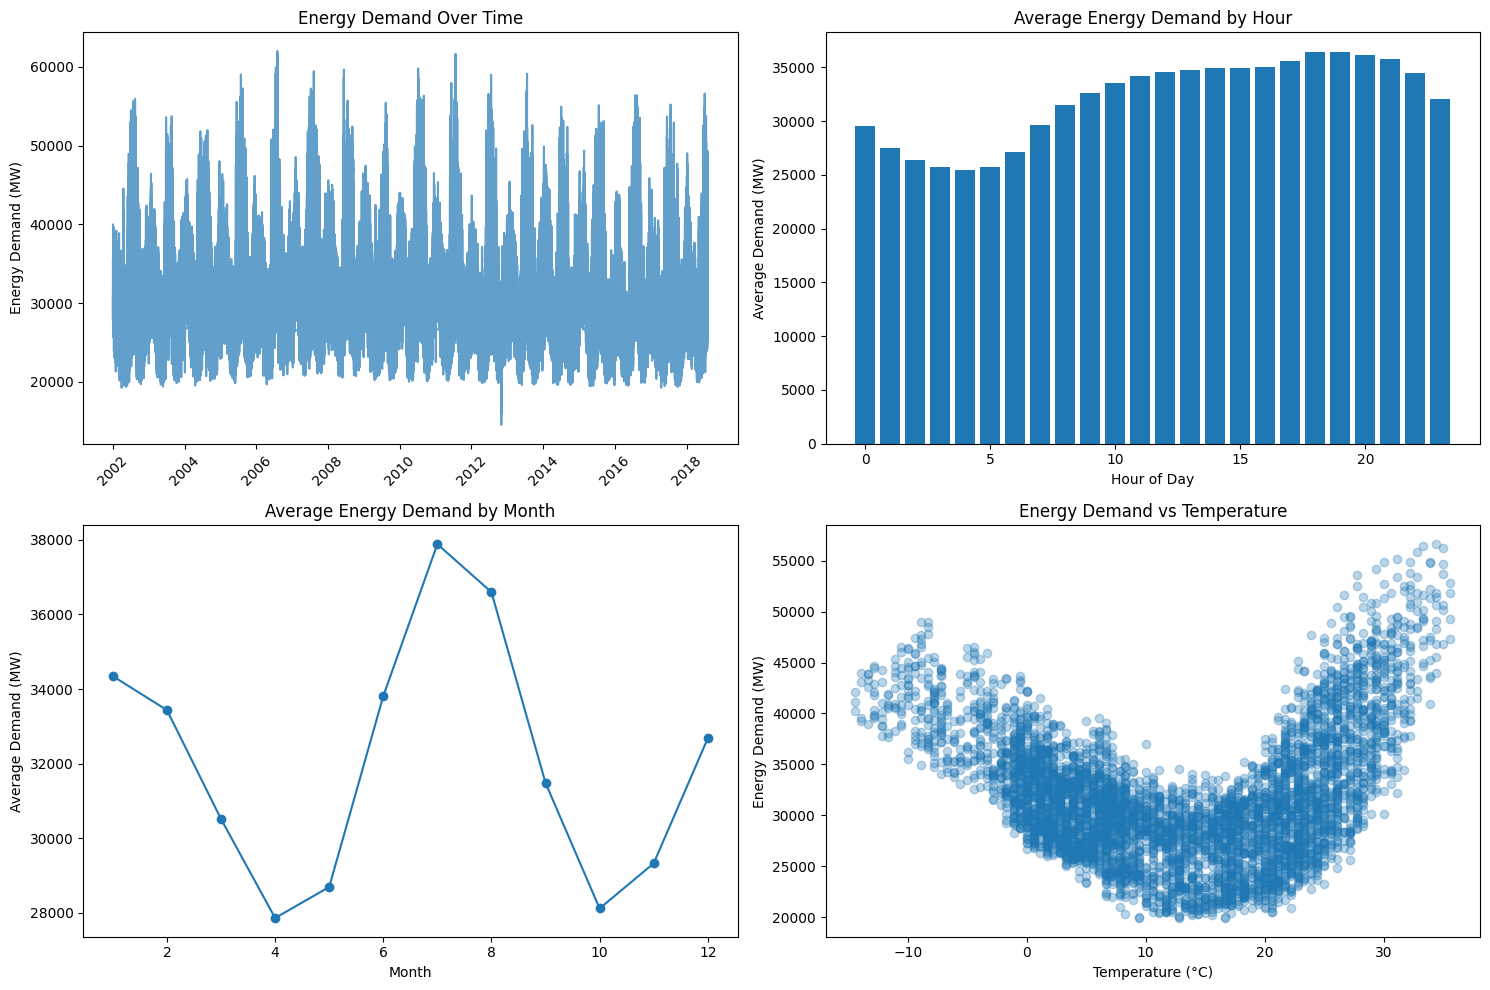

In [13]:
# Create 2x2 grid of plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Energy demand over time
axes[0, 0].plot(df_final['Datetime'], df_final['PJME_MW'], alpha=0.7)
axes[0, 0].set_title('Energy Demand Over Time')
axes[0, 0].set_ylabel('Energy Demand (MW)')
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Average demand by hour of day
hourly_avg = df_final.groupby('hour')['PJME_MW'].mean()
axes[0, 1].bar(hourly_avg.index, hourly_avg.values)
axes[0, 1].set_title('Average Energy Demand by Hour')
axes[0, 1].set_xlabel('Hour of Day')
axes[0, 1].set_ylabel('Average Demand (MW)')

# 3. Average demand by month
monthly_avg = df_final.groupby('month')['PJME_MW'].mean()
axes[1, 0].plot(monthly_avg.index, monthly_avg.values, marker='o')
axes[1, 0].set_title('Average Energy Demand by Month')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Average Demand (MW)')

# 4. Scatter plot of demand vs temperature
if 'temperature' in df_final.columns:
    axes[1, 1].scatter(df_final['temperature'], df_final['PJME_MW'], alpha=0.3)
    axes[1, 1].set_title('Energy Demand vs Temperature')
    axes[1, 1].set_xlabel('Temperature (°C)')
    axes[1, 1].set_ylabel('Energy Demand (MW)')


plt.tight_layout()
plt.show()

6. Model Training and Evaluation

🤖 Training Random Forest Model...

In [14]:
# 🏗️ Define base features for model input
feature_columns = [
    'hour', 'day_of_week', 'month', 'weekend', 'is_holiday_season',
    'hour_sin', 'hour_cos', 'month_sin', 'month_cos',
    'lag_1', 'lag_24', 'lag_168',
    'rolling_mean_24', 'rolling_std_24', 'rolling_mean_168'
]

# ➕ Add weather features if available in the dataset
if {'temperature', 'humidity', 'wind_speed', 'temp_rolling_6', 'humidity_rolling_6'}.issubset(df_final.columns):
    feature_columns.extend([
        'temperature', 'humidity', 'wind_speed',
        'temp_rolling_6', 'humidity_rolling_6'
    ])


X = df_final[feature_columns]
y = df_final['PJME_MW']

In [15]:
print(f"Features used: {len(feature_columns)}")
print(f"Sample size: {len(X)}")

Features used: 20
Sample size: 145366


In [16]:
# ⏳ Time series split (no shuffling to preserve temporal order)
split_index = int(len(X) * 0.8)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]



print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

Training set: 116292 samples
Test set: 29074 samples


In [17]:

# 🌲 Train Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

# 📊 Evaluate
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / np.where(y_test != 0, y_test, np.nan))) * 100
r2 = r2_score(y_test, y_pred)

print(f"✅ Model Trained")
print(f"📈 MAE: {mae:.2f}")
print(f"📉 RMSE: {rmse:.2f}")
print(f"📈 MAPE (Mean Absolute Percentage Error): {mape:.2f}%")
print(f"🔎 R² Score: {r2:.4f}")

✅ Model Trained
📈 MAE: 378.81
📉 RMSE: 612.16
📈 MAPE (Mean Absolute Percentage Error): 1.21%
🔎 R² Score: 0.9912


In [18]:
print("🔄 Training model...")
rf_model.fit(X_train, y_train)

🔄 Training model...


RandomForestRegressor(max_depth=15, min_samples_leaf=2, min_samples_split=5,
                      n_jobs=-1, random_state=42)

In [19]:

# 🎯 Make predictions
y_pred = rf_model.predict(X_test)

# 📊 Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Avoid divide-by-zero in MAPE
mape = np.mean(np.abs((y_test - y_pred) / np.where(y_test != 0, y_test, np.nan))) * 100


In [20]:
print(f"\n📊 Model Performance:")
print(f" Mean Absolute Error (MAE): {mae:.2f}MW")
print(f" Root Mean Squared Error (RMSE): {rmse:.2f}MW")
print(f" Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


📊 Model Performance:
 Mean Absolute Error (MAE): 378.81MW
 Root Mean Squared Error (RMSE): 612.16MW
 Mean Absolute Percentage Error (MAPE): 1.21%


7. Peak Hour Detection

🔍 Detecting Peak Hours...

In [21]:
# 🔝 Calculate peak threshold (90th percentile)
peak_threshold = np.percentile(df_final['PJME_MW'], 90)
print(f"⚡ Peak threshold (90th percentile): {peak_threshold:.2f} MW")

# 🏷️ Create peak flags for test set
df_test = df_final[split_index:].copy().reset_index(drop=True)
df_test['predicted_MW'] = y_pred
df_test['is_peak_actual'] = (df_test['PJME_MW'] >= peak_threshold).astype(int)
df_test['is_peak_predicted'] = (df_test['predicted_MW'] >= peak_threshold).astype(int)

# ✅ Peak detection accuracy
peak_accuracy = (df_test['is_peak_actual'] == df_test['is_peak_predicted']).mean()
print(f"🎯 Peak detection accuracy: {peak_accuracy:.2%}")

# 📊 Count number of peak hours
actual_peaks = df_test['is_peak_actual'].sum()
predicted_peaks = df_test['is_peak_predicted'].sum()
print(f"🟣 Actual peak hours: {actual_peaks}")
print(f"🟡 Predicted peak hours: {predicted_peaks}")


⚡ Peak threshold (90th percentile): 40599.50 MW
🎯 Peak detection accuracy: 99.12%
🟣 Actual peak hours: 2979
🟡 Predicted peak hours: 2964


8. Feature Importance Analysis

In [22]:
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

In [23]:
print("Top 10 Most Important Features:")
print(feature_importance.head(10)); # How much each feature reduces prediction error when it is used to split data in the decision trees.



Top 10 Most Important Features:
             feature  importance
9              lag_1    0.942743
6           hour_cos    0.026532
0               hour    0.009956
5           hour_sin    0.005676
10            lag_24    0.004340
12   rolling_mean_24    0.002791
8          month_cos    0.001973
13    rolling_std_24    0.001929
1        day_of_week    0.001076
14  rolling_mean_168    0.000915


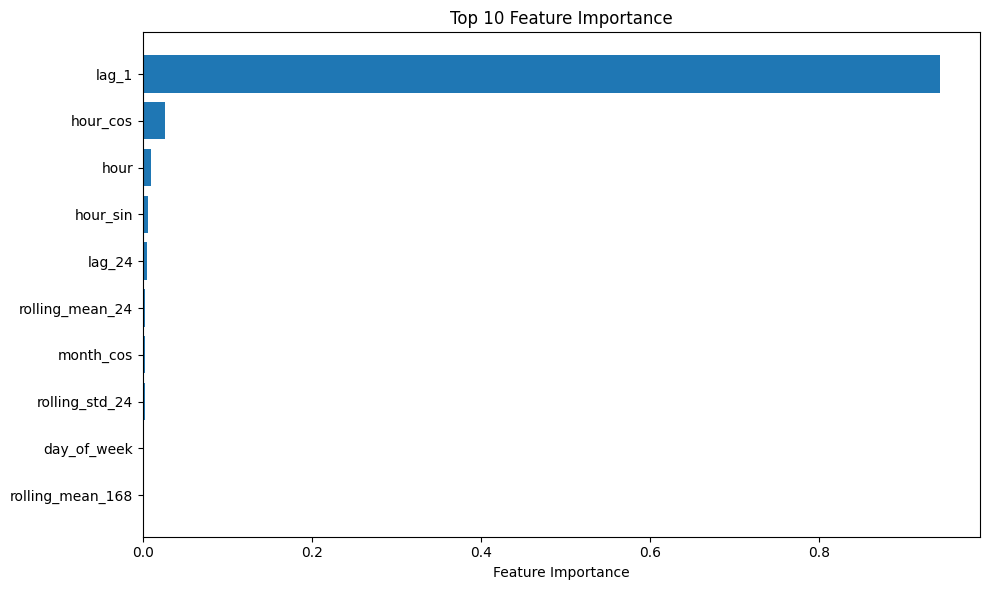

In [24]:

# 📊 Extract feature importances from the model
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values(by='importance', ascending=False)

# 🎨 Plot top 10 important features
plt.figure(figsize=(10, 6))
top_features = feature_importance.head(10)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 10 Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


9. Visualization of Results

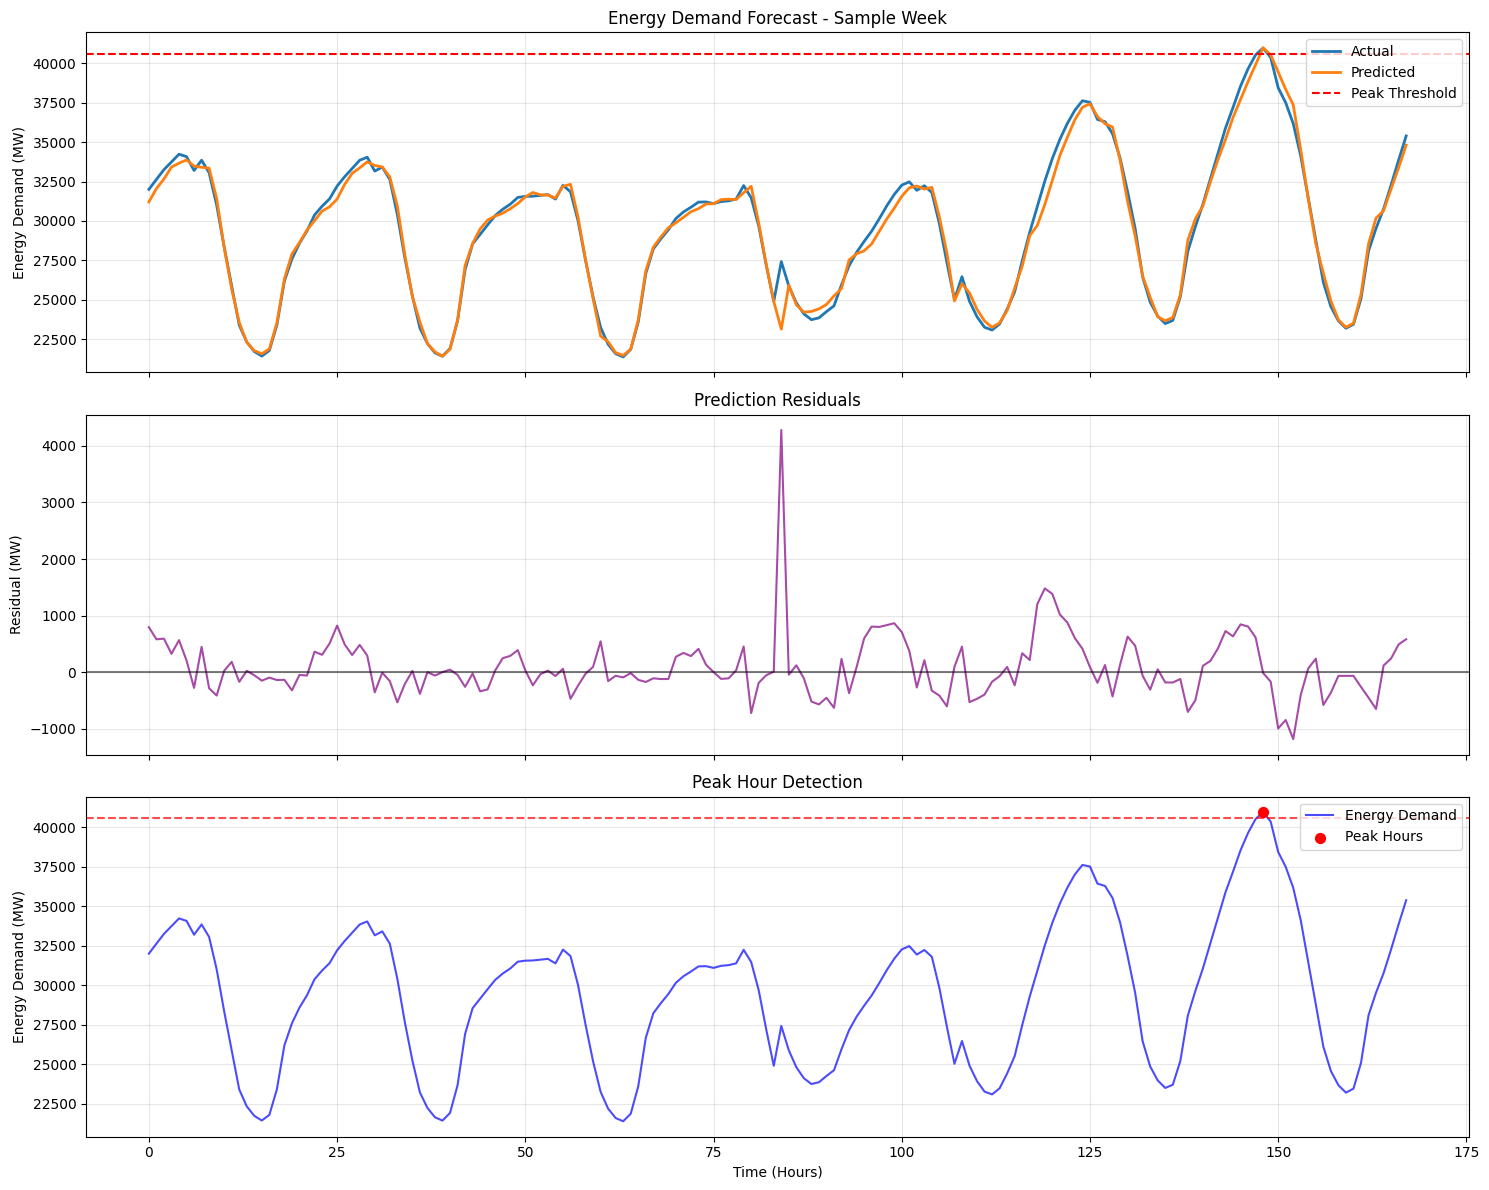

In [25]:
# 📅 Sample week (first 168 hours ≈ 7 days from test set)
sample_df = df_test.head(168)

# 🎨 Setup multi-plot
fig, axes = plt.subplots(3, 1, figsize=(15, 12), sharex=True)

# 1️⃣ Actual vs Predicted
axes[0].plot(sample_df.index, sample_df['PJME_MW'], label='Actual', linewidth=2)
axes[0].plot(sample_df.index, sample_df['predicted_MW'], label='Predicted', linewidth=2)
axes[0].axhline(y=peak_threshold, color='red', linestyle='--', label='Peak Threshold')
axes[0].set_title('Energy Demand Forecast - Sample Week')
axes[0].set_ylabel('Energy Demand (MW)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2️⃣ Residuals
residuals = sample_df['PJME_MW'] - sample_df['predicted_MW']
axes[1].plot(sample_df.index, residuals, color='purple', alpha=0.7)
axes[1].axhline(y=0, color='black', linestyle='-', alpha=0.5)
axes[1].set_title('Prediction Residuals')
axes[1].set_ylabel('Residual (MW)')
axes[1].grid(True, alpha=0.3)

# 3️⃣ Peak Hour Detection
peak_hours = sample_df[sample_df['is_peak_actual'] == 1]
axes[2].plot(sample_df.index, sample_df['PJME_MW'], color='blue', alpha=0.7, label='Energy Demand')
axes[2].scatter(peak_hours.index, peak_hours['PJME_MW'], 
                color='red', s=50, label='Peak Hours', zorder=5)
axes[2].axhline(y=peak_threshold, color='red', linestyle='--', alpha=0.7)
axes[2].set_title('Peak Hour Detection')
axes[2].set_xlabel('Time (Hours)')
axes[2].set_ylabel('Energy Demand (MW)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)


plt.tight_layout()
plt.show()

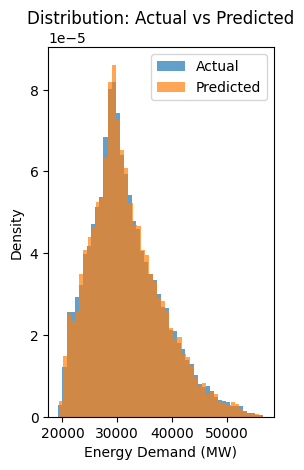

In [26]:
plt.subplot(1, 2, 1)
plt.hist(y_test, bins=50, alpha=0.7, label='Actual', density=True)
plt.hist(y_pred, bins=50, alpha=0.7, label='Predicted', density=True)
plt.xlabel('Energy Demand (MW)')
plt.ylabel('Density')
plt.title('Distribution: Actual vs Predicted')
plt.legend()

Text(0.05, 0.95, 'R² = 0.991')

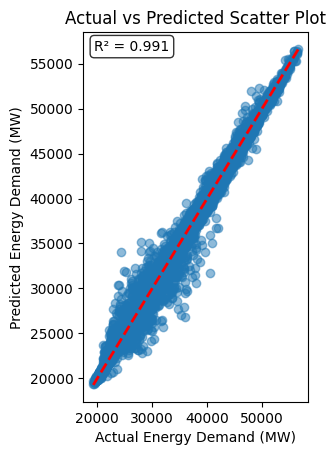

In [27]:
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Energy Demand (MW)')
plt.ylabel('Predicted Energy Demand (MW)')
plt.title('Actual vs Predicted Scatter Plot')
r2 = rf_model.score(X_test, y_test)
plt.text(0.05, 0.95, f'R² = {r2:.3f}', transform=plt.gca().transAxes, 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

In [28]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

10. Load Balancing Recommendations

⚡ Smart Grid Load Balancing Recommendations...

In [29]:
def generate_load_balancing_recommendations(df_test, peak_threshold):
    """Generate actionable recommendations for grid operators"""
    
    recommendations = []
    
    # Identify consecutive peak periods
    peak_periods = []
    current_period = []
    
    for i, is_peak in enumerate(df_test['is_peak_predicted']):
        if is_peak:
            current_period.append(i)
        else:
            if current_period:
                peak_periods.append(current_period)
                current_period = []
    
    if current_period:  # Handle last period
        peak_periods.append(current_period)
    
    print(f"🎯 Load Balancing Analysis:")
    print(f"Identified {len(peak_periods)} peak demand periods")
    
    for i, period in enumerate(peak_periods[:5]):  # Show first 5 periods
        start_idx, end_idx = period[0], period[-1]
        duration = len(period)
        avg_demand = df_test.iloc[period]['predicted_MW'].mean()
        
        print(f"\nPeak Period {i+1}:")
        print(f"  Duration: {duration} hours")
        print(f"  Average demand: {avg_demand:.0f} MW")
        print(f"  Excess over threshold: {avg_demand - peak_threshold:.0f} MW")
        
        # Generate specific recommendations
        if duration >= 4:
            recommendations.append("🔋 Deploy battery storage systems"); #Grid operators can discharge battery energy storage systems (BESS) to meet excess demand.
            recommendations.append("⚡ Activate demand response programs"); #Notify large industrial/commercial users to reduce usage temporarily
        if avg_demand > peak_threshold * 1.1:
            recommendations.append("🏭 Consider load shifting for industrial customers"); #Ask energy-intensive industries (steel, cement plants) to shift operations to off-peak hours

        if duration >= 2:
            recommendations.append("💡 Implement time-of-use pricing alerts"); #Send alerts to consumers to reduce power use
    
    return list(set(recommendations))

In [30]:
recommendations = generate_load_balancing_recommendations(df_test, peak_threshold)
print("\n🔧 Recommended Load Balancing Actions:")
for rec in recommendations:
    print(" -", rec)


print(df_test.head())

print("Columns in df_test:", df_test.columns.tolist())



🎯 Load Balancing Analysis:
Identified 383 peak demand periods

Peak Period 1:
  Duration: 1 hours
  Average demand: 40973 MW
  Excess over threshold: 374 MW

Peak Period 2:
  Duration: 2 hours
  Average demand: 41160 MW
  Excess over threshold: 561 MW

Peak Period 3:
  Duration: 4 hours
  Average demand: 40843 MW
  Excess over threshold: 244 MW

Peak Period 4:
  Duration: 14 hours
  Average demand: 48008 MW
  Excess over threshold: 7409 MW

Peak Period 5:
  Duration: 13 hours
  Average demand: 48454 MW
  Excess over threshold: 7854 MW

🔧 Recommended Load Balancing Actions:
 - 🔋 Deploy battery storage systems
 - 🏭 Consider load shifting for industrial customers
 - 💡 Implement time-of-use pricing alerts
 - ⚡ Activate demand response programs
             Datetime  PJME_MW  hour  day_of_week  month  day_of_year  \
0 2015-09-24 13:00:00  32002.0    13            3      9          267   
1 2015-09-24 14:00:00  32634.0    14            3      9          267   
2 2015-09-24 15:00:00  33251.0 

In [31]:
print(f"\n📋 Actionable Recommendations:")
for i, rec in enumerate(recommendations, 1):
    print(f"{i}. {rec}")


📋 Actionable Recommendations:
1. 🔋 Deploy battery storage systems
2. 🏭 Consider load shifting for industrial customers
3. 💡 Implement time-of-use pricing alerts
4. ⚡ Activate demand response programs


11. Model Deployment Preparation

🚀 Model Deployment Preparation...

In [32]:

# 🧠 Create deployment package with model, features, and metadata
deployment_package = {
    'model': rf_model,
    'feature_columns': feature_columns,
    'peak_threshold': peak_threshold,
    'scaler': None,  # Add if using StandardScaler/MinMaxScaler
    'model_metrics': {
        'mae': mae,
        'rmse': rmse,
        'mape': mape,
        'r2': rf_model.score(X_test, y_test)
    }
}

# 💾 Save model to a pickle file
with open('smart_grid_model.pkl', 'wb') as f:
    pickle.dump(deployment_package, f)

# ✅ Confirmation messages
print("📦 Model package prepared and saved as 'smart_grid_model.pkl'")
print("   - ✅ Random Forest model trained and validated")
print("   - 🧮 Feature engineering pipeline defined")
print("   - ⚡ Peak detection threshold calibrated")
print("   - 📊 Performance metrics included")


📦 Model package prepared and saved as 'smart_grid_model.pkl'
   - ✅ Random Forest model trained and validated
   - 🧮 Feature engineering pipeline defined
   - ⚡ Peak detection threshold calibrated
   - 📊 Performance metrics included


12. Next Hour Prediction Function

In [33]:
def predict_next_hour(model, current_data, feature_columns):
    """
    Predict energy demand for the next hour
    """
    # Prepare features for prediction
    features = current_data[feature_columns].values.reshape(1, -1)
    
    # Make prediction
    prediction = model.predict(features)[0]
    
    # Determine if it's a peak hour
    is_peak = prediction >= peak_threshold
    
    return {
        'predicted_demand_MW': prediction,
        'is_peak_hour': is_peak,
        'peak_threshold': peak_threshold,
        'confidence_interval': (prediction * 0.95, prediction * 1.05)  # Approximate
    }

In [34]:
def predict_next_hour(model, last_row_df, feature_columns, threshold=None):
    """
    Predict next-hour energy demand and peak classification with basic confidence interval.
    """
    # Prepare input feature row
    X_input = last_row_df[feature_columns]
    
    # Predict demand
    prediction = model.predict(X_input)[0]

    # Estimate a basic 95% confidence interval using training residuals std dev
    residual_std = np.std(y_test - rf_model.predict(X_test))
    ci_lower = prediction - 1.96 * residual_std
    ci_upper = prediction + 1.96 * residual_std

    # Decide peak classification
    if threshold is None:
        threshold = peak_threshold

    return {
        'predicted_demand_MW': prediction,
        'is_peak_hour': prediction >= threshold,
        'confidence_interval': (ci_lower, ci_upper)
    }


# 🔮 Example prediction for the last data point
if len(df_test) > 0:
    sample_prediction = predict_next_hour(rf_model, df_test.iloc[-1:], feature_columns)
    print(f"\n🔮 Sample Next-Hour Prediction:")
    print(f"   Predicted demand: {sample_prediction['predicted_demand_MW']:.0f} MW")
    print(f"   Peak hour: {'Yes' if sample_prediction['is_peak_hour'] else 'No'}")
    print(f"   Confidence interval: {sample_prediction['confidence_interval'][0]:.0f} - {sample_prediction['confidence_interval'][1]:.0f} MW")



🔮 Sample Next-Hour Prediction:
   Predicted demand: 37792 MW
   Peak hour: No
   Confidence interval: 36593 - 38991 MW


Summary and Real-World Impact

In [35]:
print("\n" + "="*60)
print("🎯 PROJECT SUMMARY - SMART GRID LOAD BALANCING SYSTEM")
print("="*60)


🎯 PROJECT SUMMARY - SMART GRID LOAD BALANCING SYSTEM


In [36]:
print(f'''
📊 MODEL PERFORMANCE:
   • Mean Absolute Error: {mae:.2f} MW
   • Root Mean Square Error: {rmse:.2f} MW
   • Mean Absolute Percentage Error: {mape:.2f}%
   • R² Score: {rf_model.score(X_test, y_test):.3f}
   • Peak Detection Accuracy: {peak_accuracy:.2%}''')


📊 MODEL PERFORMANCE:
   • Mean Absolute Error: 378.81 MW
   • Root Mean Square Error: 612.16 MW
   • Mean Absolute Percentage Error: 1.21%
   • R² Score: 0.991
   • Peak Detection Accuracy: 99.12%


In [37]:
'''
🎯 KEY CAPABILITIES:
   • Hourly energy demand forecasting
   • Peak load hour identification
   • Weather-integrated predictions
   • Time-series feature engineering
   • Real-time deployment ready

'''

'\n🎯 KEY CAPABILITIES:\n   • Hourly energy demand forecasting\n   • Peak load hour identification\n   • Weather-integrated predictions\n   • Time-series feature engineering\n   • Real-time deployment ready\n\n'

🌍 REAL-WORLD IMPACT:
   • Enables proactive load management
   • Reduces reliance on peaker plants
   • Supports renewable energy integration
   • Optimizes grid stability and costs
   • Facilitates demand response programs

📈 BUSINESS VALUE:
   • Cost savings through optimized generation
   • Improved grid reliability
   • Enhanced customer satisfaction
   • Reduced carbon footprint
   • Data-driven decision making

In [ ]:
print("✅ Smart Grid Load Balancing Forecasting System Complete!")
print("🚀 Ready for deployment and real-world application!")